In [1]:
#====================================================================== INSTALL PRE-REQS ==================================================================
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
# https://towardsdatascience.com/drug-discovery-with-graph-neural-networks-part-1-1011713185eb"""
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e
!pip install --pre deepchem
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import deepchem as dc
from deepchem.utils.save import load_from_disk
from deepchem.models import GraphConvModel 
from rdkit import Chem #Hell of an import
import pandas as pd #Importing panda as "pd"
from rdkit.Chem import AllChem
from rdkit.Chem import Draw #Import function to draw molecules
from itertools import chain
from rdkit.Chem import rdMolDescriptors
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from rdkit import Chem #Hell of an import
from rdkit.Chem import rdMolDescriptors
from rdkit import Chem
from rdkit.Chem import DataStructs
from rdkit.Chem import RDConfig
from rdkit import rdBase
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.EState import Fingerprinter
from rdkit.Chem import Descriptors
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, cohen_kappa_score, matthews_corrcoef
from sklearn.externals import joblib
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import statistics

--2021-05-09 05:43:00--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   222MB/s    in 0.4s    

2021-05-09 05:43:01 (222 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h

add /root/miniconda/lib/python3.7/site-packages to PYTHONPATH
python version: 3.7.10
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit, openmm, pdbfixer
added omnia to channels
added conda-forge to channels
done
conda packages installation finished!


# conda environments:
#
base                  *  /root/miniconda
                         /usr/local

     |████████████████████████████████| 561 kB 9.1 MB/s 
     |████████████████████████████████| 303 kB 11.5 MB/s 
     |████████████████████████████████| 22.3 MB 1.1 MB/s 
     |████████████████████████████████| 27.4 MB 141 kB/s 


deepchem.utils.save has been deprecated.
The utilities in save.py are moved to deepchem.utils.data_utils or deepchem.utils.genomics_utils.
/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Building QSPR Models
This section builds 2 QSPR models for predicting the critical miscelle concentration (CMC) of non-ionic surfactants using custom QSAR helper functions and a dataset of Non-ionic surfactants and their CMC values collected from literature.


In [2]:
#-------- Upload model input data (Non-Ionic surfactant data with measured CMC values from literature)
NIS = pd.read_csv('https://raw.githubusercontent.com/MarcusVaughnHarris/Data/main/ModelData/NonIonicSurfactantsCMC.csv')#Upload Data  

In [ ]:
#-------- Download Model Helper function for calculating/arranging descriptors and building sequential NN's
!wget https://raw.githubusercontent.com/MarcusVaughnHarris/QSPR/main/Model%20Helper%20Functions/SeqHelperFun.py 
runfile('/content/SeqHelperFun.py')

#-------- Define fingerprint and descriptors to calculate for input into sequential model
FingerPrintType = 'Fingerprinter.FingerprintMol'

DescriptorList = ['Descriptors.MolWt',                 'Descriptors.TPSA',                'Descriptors.NOCount',                  'Descriptors.NumHAcceptors',
                  'Descriptors.NumHDonors',            'Descriptors.NHOHCount',           'Descriptors.NumValenceElectrons',      'Descriptors.NumRotatableBonds',
                  'Descriptors.MolLogP',               'Descriptors.MolMR',               'Chem.Fragments.fr_C_O',                'Chem.Fragments.fr_ester',
                  'Chem.Fragments.fr_ether',           'Chem.Fragments.fr_NH1',           'Chem.Fragments.fr_NH2',                'Chem.Fragments.fr_unbrch_alkane',
                  'Chem.Fragments.fr_amide']

#-------- Calc and return descriptor dataframe
NIS_Descr = CalcDescr_SMIdf(NIS, FingerPrintType, DescriptorList)
NIS_Descr.head()

Epoch 1/500
5/5 [==============================] - 1s 142ms/step - loss: 8.6737 - accuracy: 0.0000e+00 - val_loss: 2.7030 - val_accuracy: 0.0000e+00
Epoch 2/500
5/5 [==============================] - 0s 14ms/step - loss: 2.0660 - accuracy: 0.0021 - val_loss: 2.2270 - val_accuracy: 0.0000e+00
Epoch 3/500
5/5 [==============================] - 0s 14ms/step - loss: 1.3695 - accuracy: 0.0129 - val_loss: 1.8366 - val_accuracy: 0.0000e+00
Epoch 4/500
5/5 [==============================] - 0s 15ms/step - loss: 1.4048 - accuracy: 0.0051 - val_loss: 1.4341 - val_accuracy: 0.0000e+00
Epoch 5/500
5/5 [==============================] - 0s 16ms/step - loss: 1.2459 - accuracy: 0.0034 - val_loss: 1.5542 - val_accuracy: 0.0000e+00
Epoch 6/500
5/5 [==============================] - 0s 13ms/step - loss: 1.1873 - accuracy: 0.0051 - val_loss: 1.6523 - val_accuracy: 0.0000e+00
Epoch 7/500
5/5 [==============================] - 0s 14ms/step - loss: 0.9649 - accuracy: 0.0077 - val_loss: 1.6920 - val_accuracy

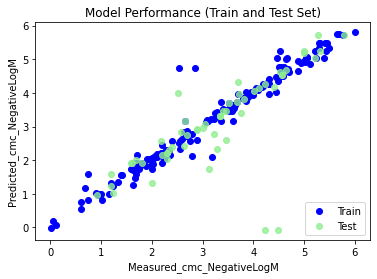

%Error (Test): -223.577 %
%Error (Train): -2.746 %
%Error (Total): 1.581 %

MAE (Test): -215.844 %
MAE (Train): 4.716 %
MAE (Total): 10.084 %

RMS (Test): 0.9251
RMS (Train): 0.3051
RMS (Total): 0.5335


In [4]:
#============================== Build Sequential QSPR model to predict CMC Non-ionic Surfs ==============================

#----- Pre-process, split data for model training/testing
Descriptors_train,  Descriptors_test,  Property_train,  Property_test = PreProcess_SMIdf(NIS_Descr,      
                                                                                        property_id = 'cmc_NegativeLogM', 
                                                                                        TestSize = 0.2)
#----- BUILDING MODEL SeqCMC 
SeqCMC = Sequential(   
                       [Dense(units = 5, input_dim = Descriptors_train.shape[1], activation='relu'),  # 2nd layer (first hidden layer)  
                        Dense(units= 10 ,  activation='relu' ), # 3rd layer (No shape needs to be specified)
                        Dense(units= 1 ,  activation='linear' )]) # Output layer

#----- COMPILE MODEL 
SeqCMC.compile(optimizer = SGD( lr=0.01, 
                                   momentum=0.9, 
                                   nesterov=True),   
                                   loss= 'mean_squared_error',    
                                   metrics = ['accuracy']) 
#----- TRAIN MODEL
SeqCMC_ModHist = SeqCMC.fit(Descriptors_train, 
                               Property_train,   
                               validation_split = 0.1,   
                               batch_size=32,   
                               epochs=500) 
#------ Plot and calculate model performance
NIS_SeqCMC = Seq_Model_performance(NIS_Descr, property_id = 'cmc_NegativeLogM', model = SeqCMC)

In [ ]:
#-------- Download Model Helper function for building Graph Convolutional NNs
!wget https://raw.githubusercontent.com/MarcusVaughnHarris/QSPR/main/Model%20Helper%20Functions/GCNNhelperFun.py
runfile('/content/GCNNhelperFun.py')

#Build Graph Convolutional QSPR model to predict CMC Non-ionic Surfs
!wget https://raw.githubusercontent.com/MarcusVaughnHarris/Data/main/ModelData/NonIonicSurfactantsCMC.csv
dataset_file= "NonIonicSurfactantsCMC.csv"

#----- PREPROCESS, BUILD, COMPILE, TRAIN, Plot and Calculate GCNN Model Performance
gcnnCMC, NIS_gcnnCMC = GCNN_Model_Creator(dataset_file, 
                                         "cmc_NegativeLogM", 
                                         "smiles",
                                         epochs = 124, 
                                         batchSize = 50 )

# Candidate Generation
This section generates molecular candidates by reacting biomass-derived precursors with various cheap/easily-accessible reactants via 1-4 step synthetic routes.


In [ ]:
#-------- Download rxn_smarts functions to help generate candidates
!wget https://raw.githubusercontent.com/MarcusVaughnHarris/QSPR/main/rxnSMARTS/RxnFun.py #CHANGE
runfile('/content/RxnFun.py')

#----- Upload Nucleophilic Reactant Data
Nucleophilic_Reactants = pd.read_csv('https://raw.githubusercontent.com/MarcusVaughnHarris/Data/main/LabReactants/Nucleophilic_Reactants.csv') 
NR = [Chem.MolFromSmiles(SMILE) for SMILE in Nucleophilic_Reactants.smiles] # N = Nucleophiles

#----- Upload Biomass Precursor Data
BioMass_precursors = pd.read_csv('https://raw.githubusercontent.com/MarcusVaughnHarris/Data/main/LabReactants/BioMassPrecursors.csv') #Using Panda function to read the dataset
BioMass_precursor_mols = [Chem.MolFromSmiles(SMILE) for SMILE in BioMass_precursors.smiles] # Convert to mol format
#----- Split precursors by type (phytol-based and fatty acid methyl ester-based)
fam = FG_split(BioMass_precursor_mols, Chem.MolFromSmarts('[#6]-[#6](-[#8])=O'), keep_group = True) # FAME precursors ('fam')
phy = FG_split(BioMass_precursor_mols, Chem.MolFromSmarts('[OH]'), keep_group = True) # Phytol precursors ('phy')

#----- Upload Electrophilic Reactant Data
Electrophilic_reactants = pd.read_csv('https://raw.githubusercontent.com/MarcusVaughnHarris/Data/main/LabReactants/Electrophilic_reactants.csv')
ER_tot = [Chem.MolFromSmiles(SMILE) for SMILE in Electrophilic_reactants.smiles]
#----- Split Electrophilic Reactants by type ( and fatty acid methyl ester-based)
ER_OH = FG_split(ER_tot, Chem.MolFromSmarts('[OH]'), keep_group = True)# Electrophilic reactants WITH Nucleophilic OH group ('ER_OH')
ER = FG_split(ER_tot, Chem.MolFromSmarts('[OH]'), keep_group = False) # Electrophilic reactants W/OUT Nucleophilic OH group ('E')

In [ ]:
#----- Phytol RXN Pathway 1 
phy_1 = Epoxidation(phy) #____(phy ---> phy_1)
phy_1_a = Nuc_ring_opening(phy_1, NR, return_format= 'Mol') #____(phy_1 ---> phy_1_a)
phy_1_a_i = Nuc_ring_opening(ER, NHOH_limit(phy_1_a, 3), return_format= 'Mol') #____(phy_1_a ---> phy_1_a_i)
phy_1_a_ii = Nuc_ring_opening(ER,   NHOH_limit(phy_1_a_i, 3)   , return_format= 'Mol') #____(phy_1_a_i ---> phy_1_a_ii)
phy_1_b  = Nuc_ring_opening(phy_1, ER_OH, return_format= 'Mol') # #____(phy_1 ---> phy_1_b)
phy_1_b_i = Nuc_ring_opening(phy_1_b,    NR,       return_format = 'Mol')#____(phy_1_b ---> phy_1_b_i)
phy_1_c = Cyclic_Carbonation(phy_1) #____(phy_1 ---> phy_1_c)
phy_1_c_i = Nuc_ring_opening(phy_1_c, NR, return_format= 'Mol') #____(phy_1_c ---> phy_1_c_i)
#----- Phytol RXN Pathway 2 
phy_2 = Nuc_ring_opening( ER_tot,  phy, return_format = 'Mol')#____(phy ---> phy_2)
phy_2_a = Nuc_ring_opening( phy_2,  NR, return_format = 'Mol')#____(phy_2 ---> phy_2_a)
#----- COMBINING Unique Products from Phytol RXN Pathway 1&2 (phy_1 & phy_2) 
all_phy_products_list = [x for l in [phy_1_a,    phy_1_a_i,   phy_1_a_ii,   phy_1_b,   phy_1_b_i,    phy_1_c_i,  phy_2,        phy_2_a] for x in l] #,phy_1_b_ii #phy_1_a_ii, phy_2_b phy_1_c_ii
all_phy_products_smiles = [Chem.MolToSmiles(mol, isomericSmiles=True) for mol in all_phy_products_list] #Mol to Smiles
all_phy_products_unique = [Chem.MolFromSmiles(smiles) for smiles in set(all_phy_products_smiles)] #Smiles to unique Mol
all_phy_products_smiles_unique = [Chem.MolToSmiles(mol, isomericSmiles=True) for mol in all_phy_products_unique] #Unique Mol to unique Smiles

#----- FAME RXN Pathway 1 
fam_1 = fame_transesterifications(fam, NR, return_format= 'Mol') #____(fam ---> fam_1)
fam_1_a = Nuc_ring_opening(ER_tot, NHOH_limit(fam_1, 4), return_format= 'Mol')
#----- FAME RXN Pathway 2 
fam_2  = fame_transesterifications(fam, ER_OH, return_format= 'Mol') #____(fam ---> fam_2)
fam_2_a = Nuc_ring_opening(fam_2,  NR, return_format = 'Mol')#____(fam_2 ---> fam_2_a)
fam_2_a_i = Nuc_ring_opening(ER_tot,  NHOH_limit(fam_2_a, 3 ), return_format = 'Mol')
fam_2_b  = fame_transesterifications(fam, NHOH_limit(fam_2,3), return_format= 'Mol') #____(fam ---> fam_2)
#----- FAME RXN Pathway 3
fam_3 = fame_reduction(fam)
fam_3_a = Nuc_ring_opening(ER_tot, fam_3, return_format= 'Mol')
fam_3_a_i = Nuc_ring_opening(ER, fam_3_a, return_format= 'Mol')
fam_3_a_ii = Nuc_ring_opening(ER, fam_3_a_i, return_format= 'Mol')
fam_3_b = Nuc_ring_opening( fam_3_a,  NR, return_format = 'Mol')#____(phy_2 ---> phy_2_a)
#----- COMBINING all fam_1 & fam_2 &fam_3 products 
all_fam_list = [x for l in [fam_1, fam_1_a, fam_2_a, fam_2_a_i, fam_2_b,fam_3_a,fam_3_a_i, fam_3_a_ii,fam_3_b  ] for x in l] #
all_fam_smiles = [Chem.MolToSmiles(mol, isomericSmiles=True) for mol in all_fam_list] #Mol to Smiles
all_fam_unique = [Chem.MolFromSmiles(smiles) for smiles in set(all_fam_smiles)] #Smiles to unique Mol
all_fam_smiles_unique = [Chem.MolToSmiles(mol, isomericSmiles=True) for mol in all_fam_unique] #Unique Mol to unique Smiles


#----- COMBINING ALL RXN PATH PRODUCTS (FAME + Phytols) 
all_phy_fam_smiles_list = [x for l in [all_fam_smiles_unique, all_phy_products_smiles_unique ] for x in l]
all_phy_fam_unique = [Chem.MolFromSmiles(smiles) for smiles in set(all_phy_fam_smiles_list)] #Smiles to unique Mol
generated_phytolFAME_surfs = [Chem.MolToSmiles(mol, isomericSmiles=True) for mol in all_phy_fam_unique] #Unique Mol to unique Smiles
GenPHY_SMIdf = pd.DataFrame({'smiles': all_phy_products_smiles_unique})
GenFAM_SMIdf = pd.DataFrame({'smiles': all_fam_smiles_unique})
print('\n\nUnique Phytol products:',len(all_phy_products_smiles_unique))
print('Unique FAME products:',len(all_fam_smiles_unique))
print('Total unique products:',len(generated_phytolFAME_surfs))
GenMols_SMIdf = pd.DataFrame({'smiles': generated_phytolFAME_surfs}) # Turn generated smiles into dataframe
GenMols_SMIdf.head()

# Applicability Domain (filter candidates)
"SimAD.py" has custom defined functions for selecting compounds in a dataset that fall within the AD of a model.

In [ ]:
!wget https://raw.githubusercontent.com/MarcusVaughnHarris/QSPR/main/Applicability%20Domain/SimAD.py 
runfile('/content/SimAD.py')

GenFam_Mols = IsoForest_OutlierEstimator(GenMols = GenMols_SMIdf,
                           TrainMols = NIS_Descr,
                           MaxSamples = len(GenMols_SMIdf))

GenMols_IF = GenFam_Mols[GenFam_Mols['GenMols_AD'] == 1]
print(GenMols_IF.head())

In [ ]:
GenMols_IF_Dist, TrainMols_Dist = Dist2Model(GenMols_IF, NIS_Descr)
GenMols_IF_Dist

# Apply QSPR Models

In [10]:
#====================================================================
#======================== Sequential Model ==========================
#====================================================================
#----Calc same descriptors used in model for newly generated molecules
GenMols_Descr = CalcDescr_SMIdf(GenMols_IF_Dist, FingerPrintType, DescriptorList )
#----- Predict property for newly generated molecules using Sequential Model
GenMols_Seq = Seq_Model_Predict(GenMols_Descr,  property_id = 'cmc_NegativeLogM',  model =  SeqCMC)
GenMols_Seq.head()

,smiles,IsoForest_AD,Dist2TrainSet,Mol,Descriptors,Predicted_cmc_NegativeLogM
32,CCCCCCCC(=O)OCC(O)C1OCC(OCC(O)CO)C1O,1.0,0.384108,<rdkit.Chem.rdchem.Mol object at 0x7f03cf0b70d0>,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 10.0,...",2.038366
87,CCCCCCCCCC(=O)OCC(O)C1OCC(OCC(O)CO)C1O,1.0,0.384108,<rdkit.Chem.rdchem.Mol object at 0x7f03cf0b7210>,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 12.0,...",3.129372
102,CCCCCCCCCCCC(=O)OCC(O)C1OCC(OCC(O)CO)C1O,1.0,0.384108,<rdkit.Chem.rdchem.Mol object at 0x7f03cf0b7170>,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 14.0,...",4.816588
33,CCCCCCCC(=O)OCC(O)COC(CO)C1OCC(O)C1O,1.0,0.382385,<rdkit.Chem.rdchem.Mol object at 0x7f03cf0b7030>,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 10.0,...",2.038366
88,CCCCCCCCCC(=O)OCC(O)COC(CO)C1OCC(O)C1O,1.0,0.382385,<rdkit.Chem.rdchem.Mol object at 0x7f03cf0b7760>,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 12.0,...",3.129372


In [11]:
#====================================================================
#======================== Graph Conv Model ==========================
#====================================================================
#----- Predict property for newly generated molecules using GCNN Model
GenMols_Descr["prop"]= (np.random.rand( GenMols_Descr.shape[0]))*max(NIS.cmc_NegativeLogM)
GenMols_Descr.to_csv('/content/GenMols_Descr.csv')
dataset_file = '/content/GenMols_Descr.csv'

GenMols_GCNN = GraphCNN_Model_Predict(dataset_file, 
                                      model = gcnnCMC,
                                      task_name = 'cmc_NegativeLogM',
                                      smiles_field = "smiles", 
                                      batchSize = 300)
GenMols_GCNN.head()

smiles_field is deprecated and will be removed in a future version of DeepChem.Use feature_field instead.
/usr/local/lib/python3.7/site-packages/deepchem/data/data_loader.py:162: FutureWarning: featurize() is deprecated and has been renamed to create_dataset().featurize() will be removed in DeepChem 3.0
  "featurize() will be removed in DeepChem 3.0", FutureWarning)


,smiles,Predicted_cmc_NegativeLogM
0,CCCCCCCC(=O)OCC(O)C1OCC(OCC(O)CO)C1O,2.561
1,CCCCCCCCCC(=O)OCC(O)C1OCC(OCC(O)CO)C1O,3.207
2,CCCCCCCCCCCC(=O)OCC(O)C1OCC(OCC(O)CO)C1O,3.835
3,CCCCCCCC(=O)OCC(O)COC(CO)C1OCC(O)C1O,1.641
4,CCCCCCCCCC(=O)OCC(O)COC(CO)C1OCC(O)C1O,2.826


/root/miniconda/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:192: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


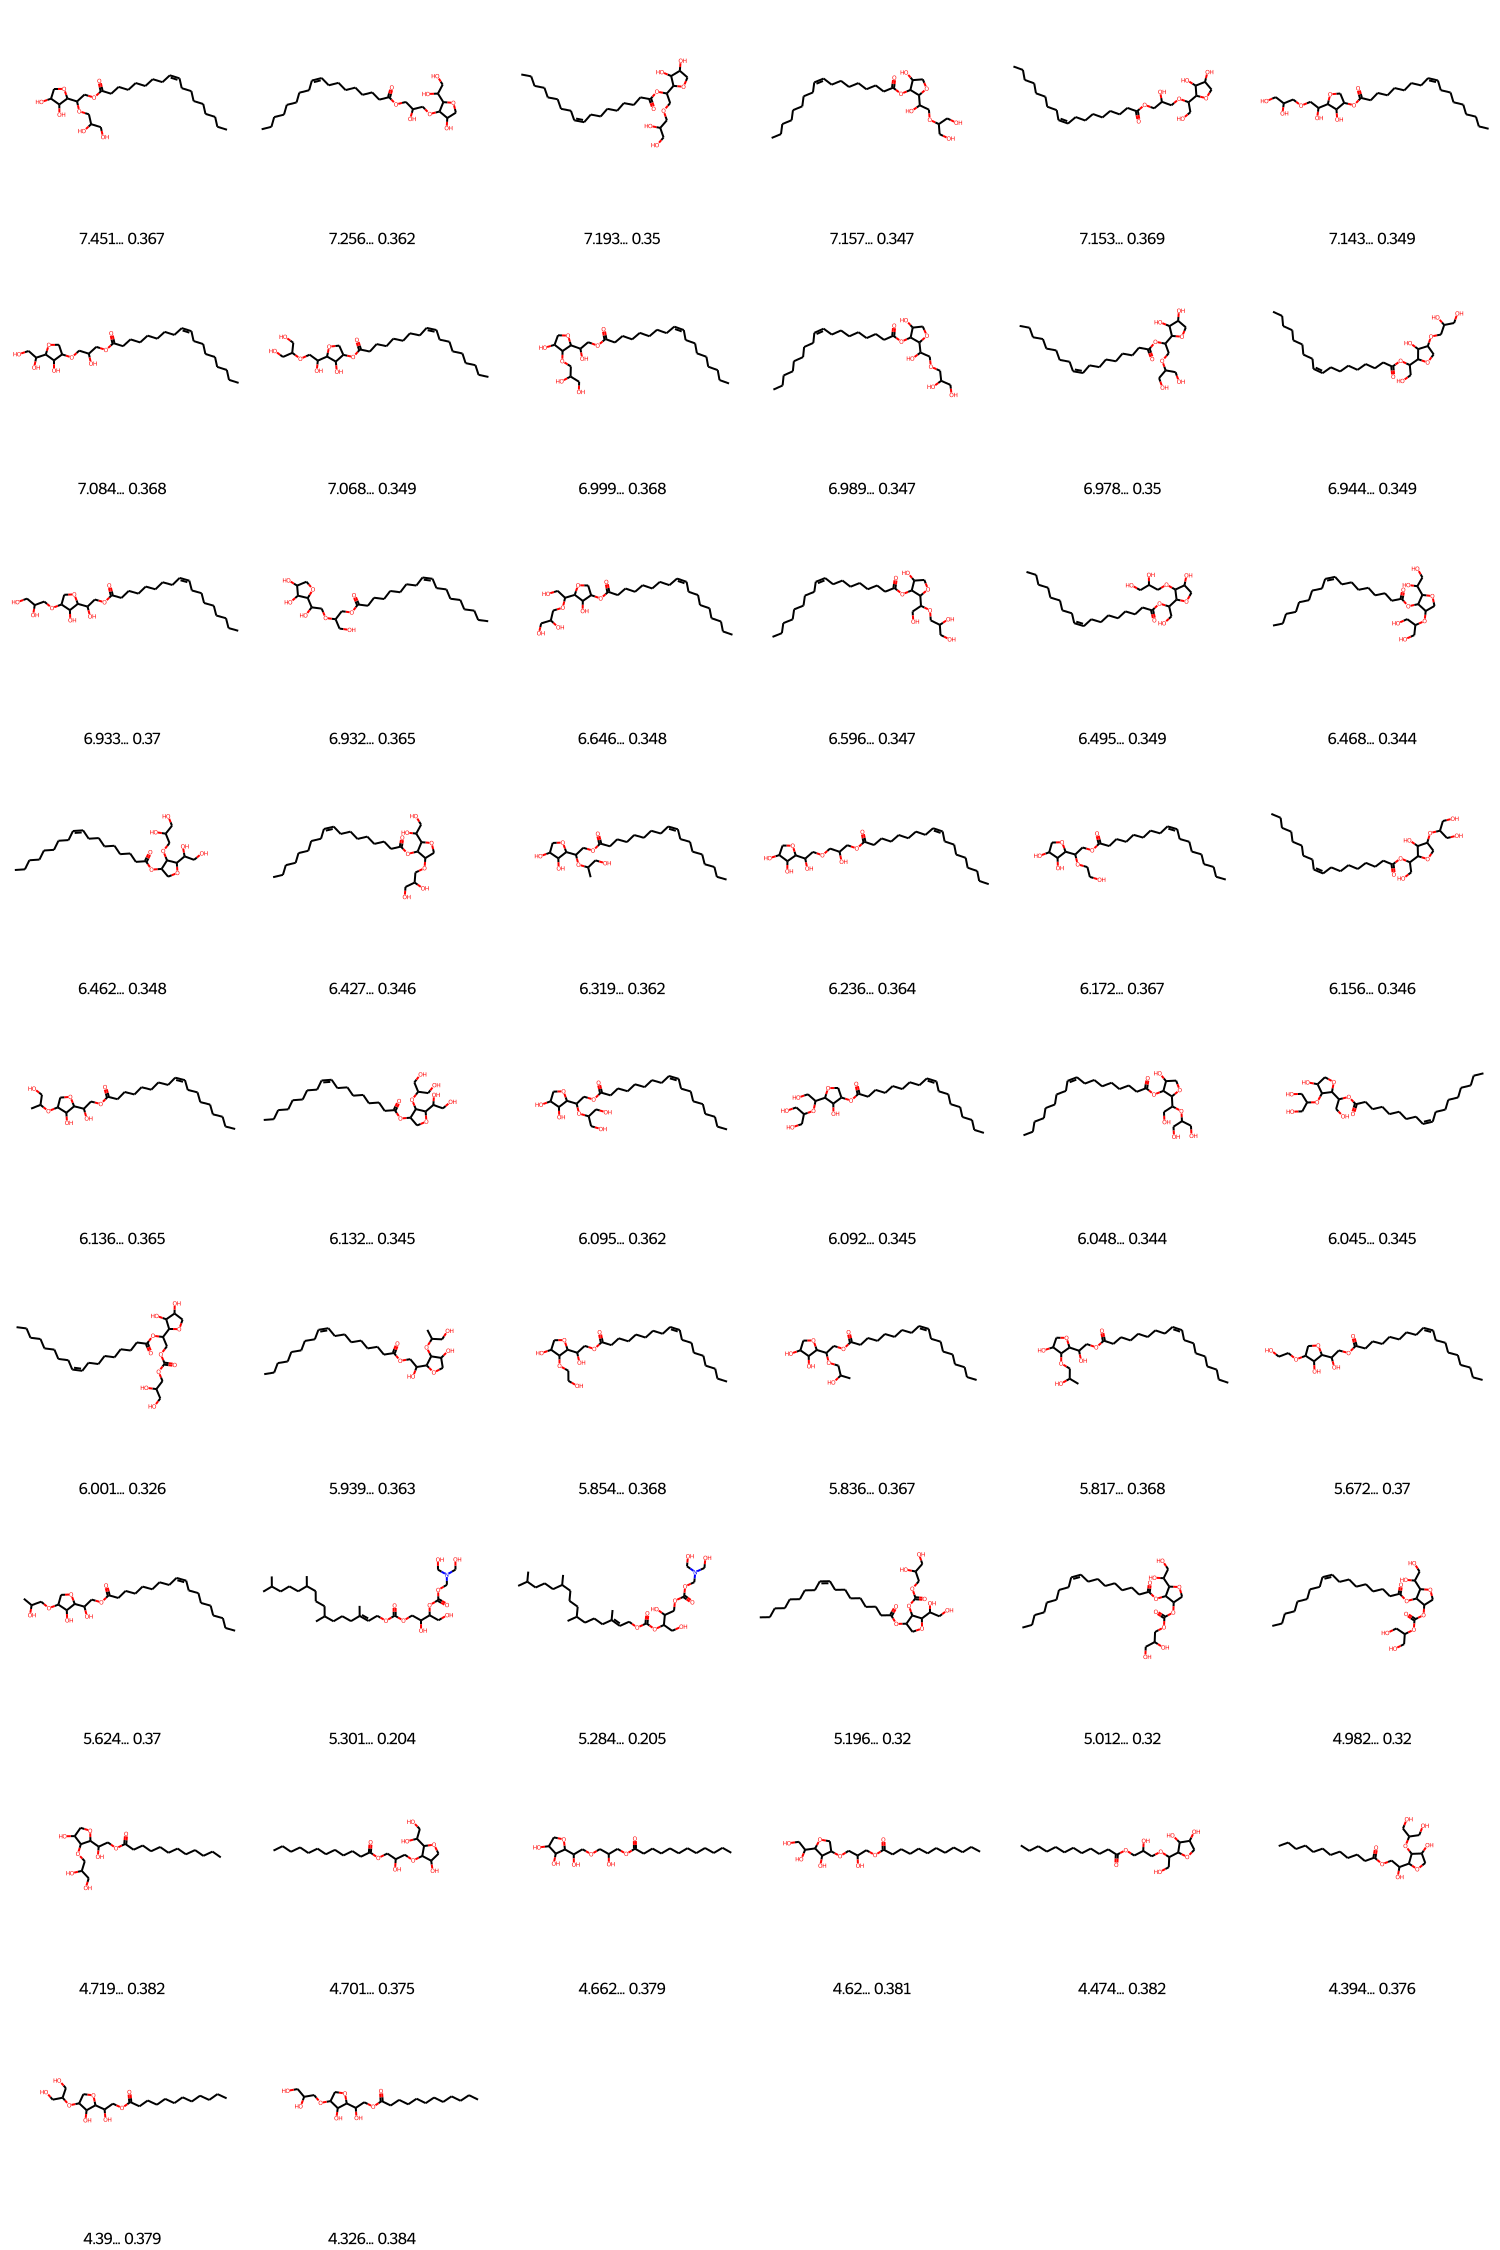

In [12]:
#----- Merge model predictions
GenMols_pred = GenMols_Seq.merge(GenMols_GCNN, left_on='smiles', right_on='smiles')

GenMols_predictions = pd.DataFrame({"smiles":GenMols_pred.smiles, 
                             "Dist2TrainSet": round(GenMols_pred.Dist2TrainSet, 3),
                             "IF_AD": GenMols_pred.IsoForest_AD,
                             "Seq_CMC": round( GenMols_pred.Predicted_cmc_NegativeLogM_x, 3),
                             "GCNN_CMC":  round(GenMols_pred.Predicted_cmc_NegativeLogM_y, 3),
                             "consensus_CMC": round((GenMols_pred.Predicted_cmc_NegativeLogM_y + GenMols_pred.Predicted_cmc_NegativeLogM_x)/2, 3),
                             "Mol": GenMols_pred.Mol })


GenMols_pred_sorted = GenMols_predictions.sort_values(by = 'consensus_CMC', ascending= False)


GenMols_pred_sorted['consensus_str'] = [str(val) for val in GenMols_pred_sorted['consensus_CMC']]
GenMols_pred_sorted['Dist2TrainSet_str'] = [str(val) for val in GenMols_pred_sorted['Dist2TrainSet']]


GenMols_pred_sorted['cons_dist_str'] = GenMols_pred_sorted[['consensus_str', 'Dist2TrainSet_str']].agg('... '.join, axis=1)


Draw.MolsToGridImage(GenMols_pred_sorted.Mol,
                    molsPerRow = 6, subImgSize = (250,250), 
                    legends = [str(val) for val in GenMols_pred_sorted.cons_dist_str])

In [13]:
"""
========================================================== E  N  D ==========================================================
"""

'\n========================================================== E  N  D ==========================================================\n'